In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import numpy as np
import xgi
from governance import *
import matplotlib.pyplot as plt

In [44]:
def create_decision_matrix(m):
    D = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            D[i, j] = random.choice([-1, 0, 1])
    return D

def create_opinions(n, m):
    D = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            D[i, j] = random.uniform(-1, 1)
    return D

def decisions_to_array(decisions):
    n = len(decisions)
    d = np.zeros(n)
    for key, val in decisions.items():
        if val:
            d[key] = 1
        else:
            d[key] = -1
    return d


In [45]:
num_decisions = 20
num_people = 100
opinions = create_opinions(num_people, num_decisions)
decision_matrix = create_decision_matrix(num_decisions)

In [46]:
group_size = 3
overlap = 1

decisions, final_opinions, decision_groups = decision_process(opinions, decision_matrix, group_size, overlap, select_decision_type="random", select_group_type="random",make_decision_type="average",update_opinions_type="average")
d = decisions_to_array(decisions)

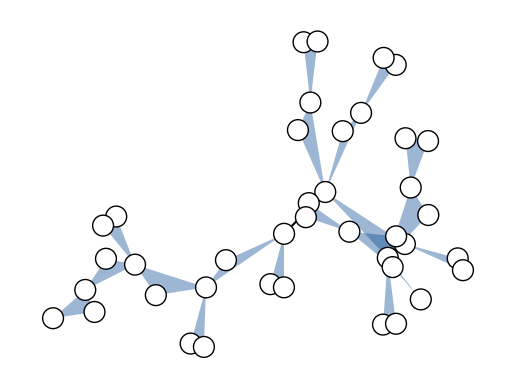

In [47]:
xgi.draw(decision_groups)

In [48]:
num_samples = 1000
group_sizes = np.arange(2, 11, 1, dtype=int)
satisfaction_group_size = np.zeros(len(group_sizes))
overlap = min(group_sizes) - 1
H_group_sizes = dict()

for i in range(len(group_sizes)):
    g = group_sizes[i]
    for j in range(num_samples):
        decisions, final_opinions, decision_groups = decision_process(opinions, decision_matrix, group_size, overlap, select_decision_type="random", select_group_type="random",make_decision_type="average",update_opinions_type="average")
        H_group_sizes[(g, overlap, j)] = decision_groups
        d = decisions_to_array(decisions)
        satisfaction_group_size[i] += np.mean(final_opinions.dot(d))/num_samples

In [49]:
num_samples = 1000
overlap_sizes = np.arange(2, 11, 1, dtype=int)
satisfaction_overlap_size = np.zeros(len(group_sizes))
group_size = max(overlap_sizes) + 1

H_overlap_sizes = dict()

for i in range(len(overlap_sizes)):
    o = overlap_sizes[i]
    for j in range(num_samples):
        decisions, final_opinions, decision_groups = decision_process(opinions, decision_matrix, group_size, overlap, select_decision_type="random", select_group_type="random",make_decision_type="average",update_opinions_type="average")
        H_overlap_sizes[(group_size, o, j)] = decision_groups
        d = decisions_to_array(decisions)
        satisfaction_overlap_size[i] += np.mean(final_opinions.dot(d))/num_samples

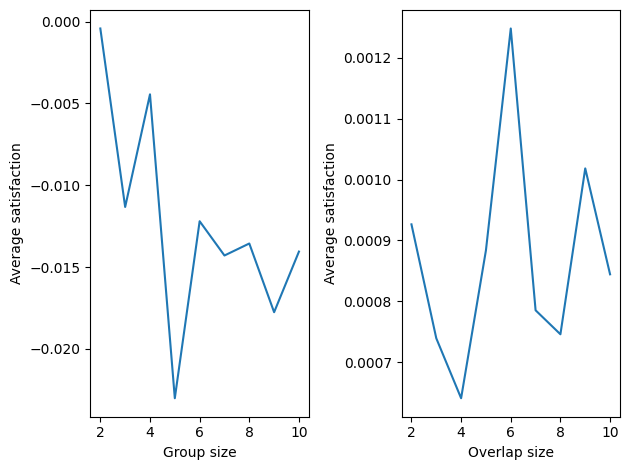

In [50]:
plt.figure()
plt.subplot(121)
plt.plot(group_sizes, satisfaction_group_size)
plt.ylabel("Average satisfaction")
plt.xlabel("Group size")
plt.subplot(122)
plt.plot(overlap_sizes, satisfaction_overlap_size)
plt.ylabel("Average satisfaction")
plt.xlabel("Overlap size")
plt.tight_layout()
plt.show()

In [10]:
np.mean(opinions.dot(d))

-0.12191001286501155